[View in Colaboratory](https://colab.research.google.com/github/gmihaila/toy_models/blob/master/seq2seq_translator.ipynb)

## Text Translation
### It uses Encoder-Decoder architecture with repeat vector.

by GeorgeM.


In [0]:
#@title
!apt-get -qq install -y graphviz && pip install -q pydot

In [2]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

--2018-05-26 16:17:26--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2400:cb00:2048:1::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4012023 (3.8M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   3.83M  3.61MB/s    in 1.1s    

2018-05-26 16:17:27 (3.61 MB/s) - ‘deu-eng.zip’ saved [4012023/4012023]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [0]:
import sys
import string
import re
from unicodedata import normalize
from numpy import array
from numpy import argmax

from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu

import pydot
from IPython.display import Image

In [2]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, mode='rt', encoding='utf-8')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# split a loaded document into sentences
def to_pairs(doc):
  lines = doc.strip().split('\n')
  pairs = [line.split('\t') for line in  lines]
  return pairs

# clean a list of lines
def clean_pairs(lines):
  cleaned = list()
  # prepare regex for char filtering
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for pair in lines:
    clean_pair = list()
    for line in pair:
      # normalize unicode characters
      line = normalize('NFD', line).encode('ascii', 'ignore')
      line = line.decode('UTF-8')
      # tokenize on white space
      line = line.split()
      # convert to lowercase
      line = [word.lower() for word in line]
      # remove punctuation from each token
      line = [word.translate(table) for word in line]
      # remove non-printable chars form each token
      line = [re_print.sub('', w) for w in line]
      # remove tokens with numbers in them
      line = [word for word in line if word.isalpha()]
      # store as string
      clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
  return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
  dump(sentences, open(filename, 'wb'))
  print('Saved: %s' % filename)

# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(10):
  print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[go on] => [mach weiter]
[hello] => [hallo]


In [3]:
# load a clean dataset
def load_clean_sentences(filename):
  return load(open(filename, 'rb'))


# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')


Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [0]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# max sentence length
def max_length(lines):
  return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
  ylist = list()
  for sequence in sequences:
    encoded = to_categorical(sequence, num_classes=vocab_size)
    ylist.append(encoded)
  y = array(ylist)
  y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
  return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units, return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model

# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
  prediction = model.predict(source, verbose=0)[0]
  integers = [argmax(vector) for vector in prediction]
  target = list()
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
    actual.append(raw_target.split())
    predicted.append(translation.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [5]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

English Vocabulary Size: 2315
English Max Length: 5
German Vocabulary Size: 3686
German Max Length: 10


In [6]:
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           943616    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2315)           594955    
Total params: 2,589,195
Trainable params: 2,589,195
Non-trainable params: 0
_________________________________________________________________
None


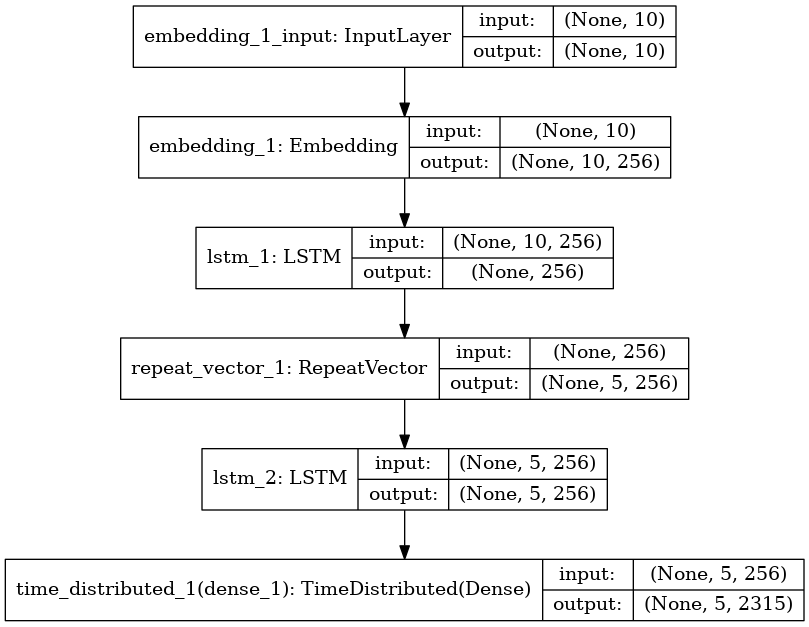

In [7]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [13]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
 - 7s - loss: 0.4126 - val_loss: 2.0727

Epoch 00001: val_loss improved from inf to 2.07269, saving model to model.h5
Epoch 2/30
 - 7s - loss: 0.3805 - val_loss: 2.0650

Epoch 00002: val_loss improved from 2.07269 to 2.06503, saving model to model.h5
Epoch 3/30
 - 7s - loss: 0.3486 - val_loss: 2.0634

Epoch 00003: val_loss improved from 2.06503 to 2.06338, saving model to model.h5
Epoch 4/30
 - 7s - loss: 0.3214 - val_loss: 2.0685

Epoch 00004: val_loss did not improve from 2.06338
Epoch 5/30
 - 7s - loss: 0.2982 - val_loss: 2.0556

Epoch 00005: val_loss improved from 2.06338 to 2.05560, saving model to model.h5
Epoch 6/30
 - 7s - loss: 0.2740 - val_loss: 2.0779

Epoch 00006: val_loss did not improve from 2.05560
Epoch 7/30
 - 7s - loss: 0.2541 - val_loss: 2.0854

Epoch 00007: val_loss did not improve from 2.05560
Epoch 8/30
 - 7s - loss: 0.2351 - val_loss: 2.0881

Epoch 00008: val_loss did not improve from 2.05560
Epoch 9/30
 

 - 7s - loss: 0.1025 - val_loss: 2.2461

Epoch 00030: val_loss did not improve from 2.05560


In [24]:

# load a clean dataset
def load_clean_sentences(filename):
  return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# max sentence length
def max_length(lines):
  return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
  prediction = model.predict(source, verbose=0)[0]
  integers = [argmax(vector) for vector in prediction]
  target = list()
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
    actual.append(raw_target.split())
    predicted.append(translation.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)



train
src=[frauen lieben tom], target=[women like tom], predicted=[women like tom]
src=[bis dann], target=[see you then], predicted=[see you then]
src=[ich bin lehrerin], target=[im a teacher], predicted=[i a a teacher]
src=[du weit das], target=[you know this], predicted=[you know this]
src=[wer betrog], target=[who cheated], predicted=[who cheated]
src=[nimm dir von dem schinken], target=[have some ham], predicted=[have some ham]
src=[ich brauche einen arzt], target=[i need a medic], predicted=[i need a medic]
src=[das ist ein lowe], target=[this is a lion], predicted=[this is a lion]
src=[lasst mich sehen], target=[let me see that], predicted=[let me see]
src=[ich kann mich nicht mit tom treffen], target=[i cant see tom], predicted=[i cant see tom]


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.076043
BLEU-2: 0.003463
BLEU-3: 0.032511
BLEU-4: 0.056909
test
src=[wir mussen gehen], target=[we need to go], predicted=[we need to go]
src=[wirf ihn mir ruber], target=[throw it to me], predicted=[show it to me]
src=[ich sitze in der patsche], target=[i am in trouble], predicted=[i made by bus]
src=[tom kannte sie], target=[tom knew it], predicted=[tom knew it]
src=[sie stand zum verkauf an], target=[it was on sale], predicted=[tom pinched him]
src=[die dinge sind in ordnung], target=[things are fine], predicted=[theyre are]
src=[tom liebt kinder], target=[tom loves kids], predicted=[tom loves guns]
src=[ich bin drauen], target=[im out of here], predicted=[im freaked out]
src=[das ist schon], target=[its beautiful], predicted=[this is big]
src=[tom wurde reich], target=[tom became rich], predicted=[tom is rich]


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.078244
BLEU-2: 0.275525
BLEU-3: 0.455874
BLEU-4: 0.517030


In [15]:
ls

_about.txt   deu.txt                  english-german-test.pkl   model.png
datalab/     english-german-both.pkl  english-german-train.pkl
deu-eng.zip  english-german.pkl       model.h5


#### ref: https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/ 